## Use the ProcessWordle Module

In [1]:
from importlib import reload
from ProcessWordle import ScrabblePoints, ParseWordle
import censoring

In [3]:
sp = ScrabblePoints(censoring.wordle_answers_input)
sp.read_wordle_answers()
sp.add_total_and_difficulty()

pw = ParseWordle(
    censoring.raw_whatsapp_input, 
    censoring.wordle_output,
    censoring.name_alias
)
pw.create_wordle_df()
pw.process_data_frame()
pw.join_data_frames(sp.words_df)
pw.write_final_df()

## Import Modules for PYMC

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import censoring

RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Load Data

In [72]:
# load data
df = pd.read_csv(censoring.wordle_output)

## One more layer of processing

It turns out that if someone does not participate, then they will have a lower score (lower rate of fails) then someone who did particpate.
Thus, the contest should only be around puzzles which have equal contributions. 

In [73]:
# limit to the puzzle in which we last have words
df2 = df[ (df['PuzzleNum'] < 467) & 
         (df['PuzzleNum'] != 421) & 
         (df['Difficulty'] != 'Undefined') & 
         (df['Name'] != 'Player7') & 
         (df['Name'] != 'Player8')
        ].copy()

# how many players participated, per puzzle? 
puzzle_count_df = df2[['Name','PuzzleNum']].groupby(['PuzzleNum']).agg('count').reset_index()
# list of puzzles which have 6 people, even
list_of_puzzles = puzzle_count_df[ puzzle_count_df['Name'] == 6 ]['PuzzleNum'].tolist()
# over-write previous dataframe 
df2 = df2[ df2['PuzzleNum'].isin(list_of_puzzles)].copy()

<AxesSubplot:>

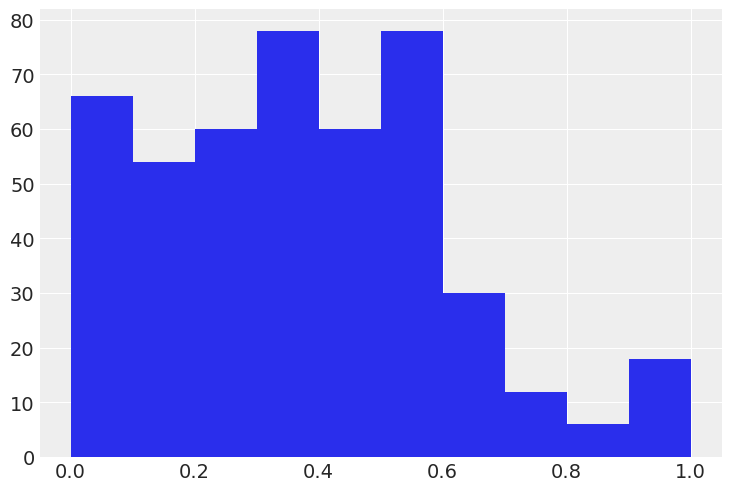

In [74]:
# standardize the 'ScrabblePoints' field
df2['StdScrblPts'] = ( df2['ScrabblePoints'] - df2['ScrabblePoints'].mean() ) / ( df2['ScrabblePoints'].std() + 1 )
# min-max the 'ScrabblePoints' field
df2['MMScrblPts'] = ( df2['ScrabblePoints']-df2['ScrabblePoints'].min())/(df['ScrabblePoints'].max()-df['ScrabblePoints'].min())
# display
df2['MMScrblPts'].hist()

<AxesSubplot:>

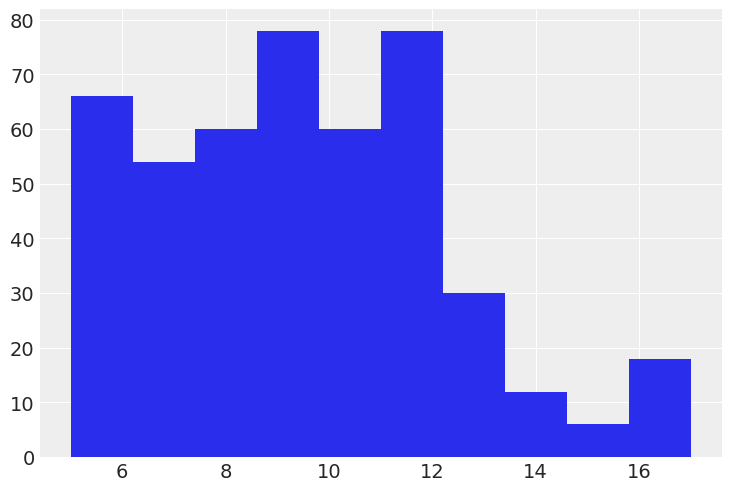

In [19]:
df2['ScrabblePoints'].hist()

## Reshape so that each player is one-hot encoded
This ensures that each player is treated independently of the others. 
Currently, Models 0 and 1 are using a 'player dimension' which is effectively saying that each of the players comes from the same distribution. 
This is not correct. 

In [75]:
df3 = pd.concat([df2[['PuzzleNum','Fails','ScrabblePoints', 'Difficulty']], pd.get_dummies(df2['Name'])], axis=1, ignore_index=True)

df3 = df3.rename(columns={
    0 : 'PuzzleNum', 
    1 : 'Fails', 
    2 : 'ScrabblePoints', 
    3 : 'Difficulty', 
    4 : 'Player1', 
    5 : 'Player2', 
    6 : 'Player3', 
    7 : 'Player4', 
    8 : 'Player5', 
    9 : 'Player6'
})

,PuzzleNum,Fails,ScrabblePoints,Difficulty,Player1,Player2,Player3,Player4,Player5,Player6
21,200,5,6.0,Easy,1,0,0,0,0,0
22,200,6,6.0,Easy,0,0,0,1,0,0
23,200,2,6.0,Easy,0,0,0,0,0,1
24,200,3,6.0,Easy,0,1,0,0,0,0
26,200,4,6.0,Easy,0,0,0,0,1,0


## Create dimensions for PYMC

In [5]:
name_factor, player_names = pd.factorize(df2['Name'], sort=True)
diff_factor, diff_categ = pd.factorize(df2['Difficulty'], sort=True)
puzz_factor, puzz_categ = pd.factorize(df2['PuzzleNum'], sort=True)

coords = {
    "obs": df2.index.values,  
    "player_names": player_names,
    "diff_categ": diff_categ,
    "puzz_categ": puzz_categ
}

## Model 0 - Using numerical scrabble values as an indpendent variable

In [6]:
with pm.Model(coords=coords) as BB0:
    
    # bring in the ScrabblePoints as X
    X = pm.MutableData("X", df2['MMScrblPts'].values)
    
    # Names
    NamesΘα = pm.Gamma("NamesΘα", alpha=1, beta=1, dims="player_names")
    NamesΘβ = pm.Gamma("NamesΘβ", alpha=1, beta=1, dims="player_names")
    
    # Difficulty
    PuzzΘα = pm.Gamma("PuzzΘα", alpha=1, beta=1)
    PuzzΘβ = pm.Gamma("PuzzΘβ", alpha=1, beta=1)
    
    # likelihood
    Fails = pm.BetaBinomial(
        "Fails", 
        n=6, 
        alpha=NamesΘα[name_factor] + PuzzΘα * X[puzz_factor], 
        beta=NamesΘβ[name_factor] + PuzzΘβ * X[puzz_factor],
        observed=df2["Fails"].values
    )

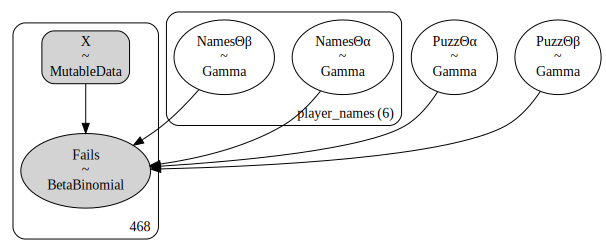

In [7]:
pm.model_to_graphviz(BB0)

In [8]:
with BB0:
    trace0 = pm.sample(
        draws=1000,
        tune=2000,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [NamesΘα, NamesΘβ, PuzzΘα, PuzzΘβ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 203 seconds.


## Model 1 - Using a categorical 'factor' to represent puzzle difficulty

In [6]:
with pm.Model(coords=coords) as BB1:
    
    # using pm.data
    y = pm.MutableData("y", df2['Fails'].to_numpy(), dims="obs")
    
    # Names
    NamesΘα = pm.Gamma("NamesΘα", alpha=3, beta=3, dims="player_names")
    NamesΘβ = pm.Gamma("NamesΘβ", alpha=3, beta=3, dims="player_names")
    
    # Difficulty
    DiffΘα = pm.Gamma("DiffΘα", alpha=3, beta=3, dims="diff_categ")
    DiffΘβ = pm.Gamma("DiffΘβ", alpha=3, beta=3, dims="diff_categ")
    
    # Names/Difficulty interaction
    interθα = pm.Gamma("interθα", alpha=3, beta=3, dims=("player_names", "diff_categ"))
    interθβ = pm.Gamma("interθβ", alpha=3, beta=3, dims=("player_names", "diff_categ"))
    
    # likelihood
    Fails = pm.BetaBinomial(
        "Fails", 
        n=6, 
        alpha=NamesΘα[name_factor] + DiffΘα[diff_factor] + interθα[name_factor, diff_factor], 
        beta=NamesΘβ[name_factor] + DiffΘβ[diff_factor] + interθβ[name_factor, diff_factor], 
        observed=y,
        dims="obs"
    )

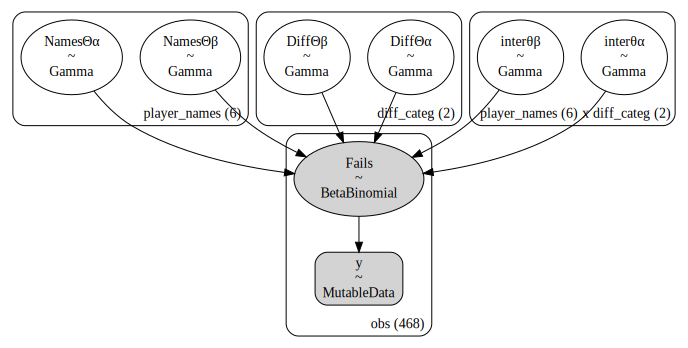

In [7]:
pm.model_to_graphviz(BB1)

In [8]:
with BB1:
    trace1 = pm.sample(
        draws=1000,
        tune=2000,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [NamesΘα, NamesΘβ, DiffΘα, DiffΘβ, interθα, interθβ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 268 seconds.


In [9]:
with BB1:
    ppc_data = pm.sample_posterior_predictive(trace1, extend_inferencedata=True)

<AxesSubplot:xlabel='Fails / Fails'>

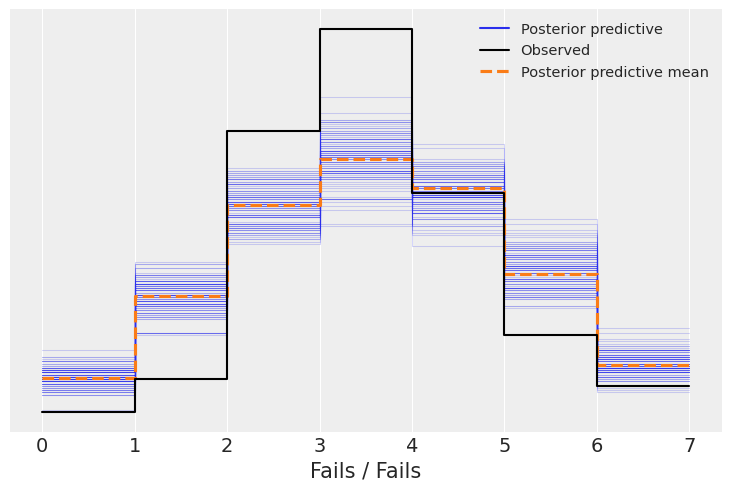

In [10]:
az.plot_ppc(ppc_data, num_pp_samples=100)

## Model 2
This seems like it will be the most correct version. Here, the players are completely independent of each other ( as separate columns ). 
I will add a 'difficulty' dimension and a 'puzzle' dimension in the future. 

In [91]:
with pm.Model(coords=coords) as BB2:
    
    # using pm.data
    y = pm.MutableData("y", df3['Fails'].to_numpy())
    x = pm.MutableData("x", df3[['PuzzleNum','ScrabblePoints','Player1','Player2','Player3','Player4','Player5','Player6']].to_numpy())
    
    # Names
    # Namesα = pm.Normal("Namesα", mu=0, sigma=5) # pm.Gamma("Namesα", alpha=1, beta=1)
    Namesβ = pm.Gamma("Namesβ", alpha=6, beta=3, shape=6)
    Namesα = pm.Gamma("Namesα", alpha=6, beta=3, shape=6)
    
    # Difficulty
    # Diffα = pm.Normal("Diffα", mu=0, sigma=5) # pm.Gamma("Diffα", alpha=1, beta=1)
    # Diffβ = pm.Gamma("Diffβ", alpha=6, beta=3)
    
    # Puzzles 
    #Puzzα = pm.Gamma("Puzzα", alpha=3, beta=3)
    #Puzzβ = pm.Gamma("Puzzβ", alpha=3, beta=3)
    

    # likelihood
    # θα = pm.Deterministic("θα", 1)
    θβ = pm.Deterministic("θβ", pm.math.dot(x[:,2:], Namesβ)) # + Diffβ * x[:,1])
    θα = pm.Deterministic("θα", pm.math.dot(x[:,2:], Namesα)) # + Diffβ * x[:,1])
    
    # response
    Fails = pm.BetaBinomial(
        "Fails", 
        n=6, 
        alpha=θα, 
        beta=θβ, 
        observed=y
    )

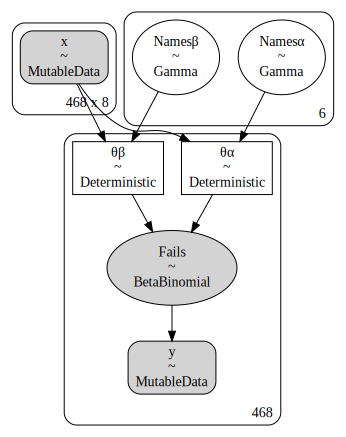

In [92]:
pm.model_to_graphviz(BB2)

In [93]:
with BB2:
    trace2 = pm.sample(
        draws=1000,
        tune=2000,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Namesβ, Namesα]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 198 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

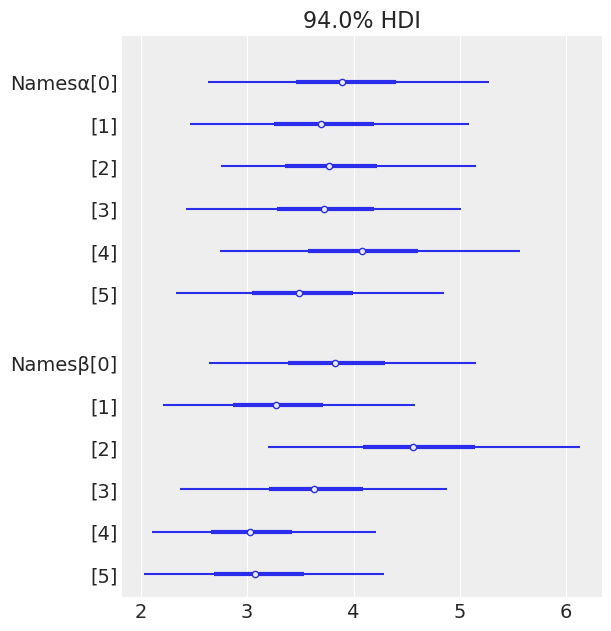

In [96]:
az.plot_forest(trace2, var_names=['Namesα', 'Namesβ'], combined=True)

## Summary of Model 2

In [98]:
az.summary(trace2, var_names=['Namesβ', 'Namesα'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Namesβ[0],3.856,0.679,2.639,5.153,0.010,0.007,5011.0,2283.0,1.0
Namesβ[1],3.312,0.634,2.212,4.575,0.009,0.007,4844.0,2979.0,1.0
Namesβ[2],4.635,0.796,3.199,6.129,0.011,0.008,4926.0,3195.0,1.0
Namesβ[3],3.675,0.677,2.364,4.878,0.009,0.007,5774.0,2986.0,1.0
Namesβ[4],3.068,0.571,2.102,4.215,0.008,0.006,5809.0,3006.0,1.0
Namesβ[5],3.134,0.619,2.032,4.286,0.008,0.006,5434.0,3095.0,1.0
Namesα[0],3.953,0.709,2.634,5.272,0.010,0.007,5260.0,2694.0,1.0
Namesα[1],3.751,0.709,2.465,5.085,0.010,0.008,5135.0,2807.0,1.0
Namesα[2],3.816,0.650,2.757,5.150,0.009,0.007,4708.0,3133.0,1.0
Namesα[3],3.771,0.694,2.429,5.014,0.009,0.007,5847.0,3261.0,1.0


## Compare Models 0 & 1
'p_waic' refers to the effective number of parameters; elpd_waic refers to the 'expected log pointwise predictive density'.

In [12]:
# Display Widely-Acceptable Information Criterion
az.compare({'BB0': trace0, 'BB1': trace1}, 'waic')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
BB0,0,-744.284898,4.414138,0.000000,0.574372,7.692477,0.000000,False,log
BB1,1,-744.858220,4.351879,0.573322,0.425628,7.096823,2.964167,False,log


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

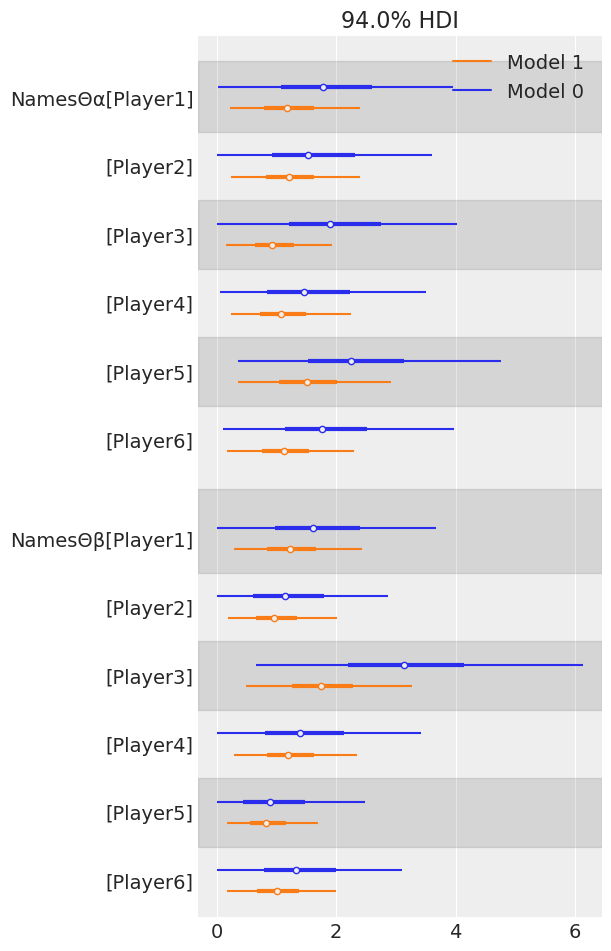

In [13]:
# plot coefficients
az.plot_forest([trace0, trace1], var_names=['NamesΘα', 'NamesΘβ'], combined=True)

## Model 1: Additional Factors

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

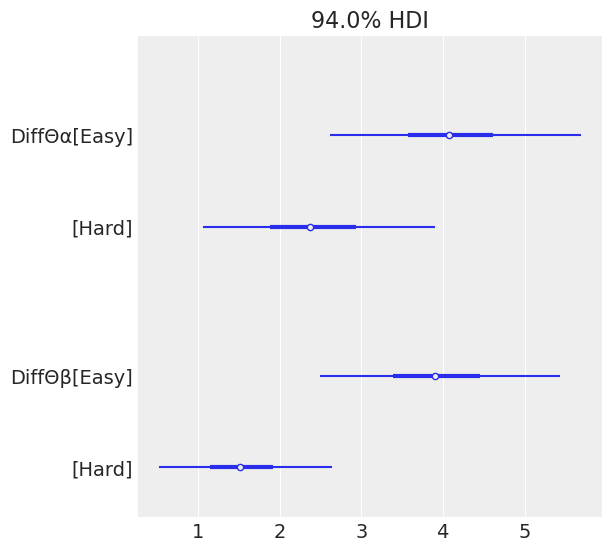

In [14]:
# az.summary(trace1, var_names=['NamesΘα', 'NamesΘβ'])
az.plot_forest(trace1, var_names=['DiffΘα', 'DiffΘβ'], combined=True)

## Model 1: Factor-interactions

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

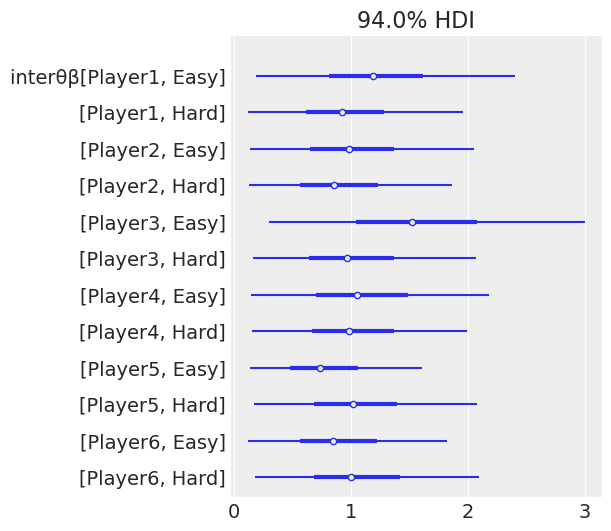

In [15]:
az.plot_forest(trace1, var_names=['interθβ'], combined=True)